In [4]:
client.restart()

Client Scheduler: tcp://scheduler:8786 Dashboard: http://scheduler:8787,Cluster Workers: 1 Cores: 8 Memory: 31.62 GB


In [3]:
%load_ext memory_profiler

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
from dask.dot import dot_graph
import itertools
import logging
import netCDF4
import numpy as np
import dask.array as da
from dask import delayed
import time
from dask.distributed import Client
from urllib import request
from multiprocessing import Pool


client = Client('scheduler:8786')
#client = Client(processes=False)

download_location = '/temp'
data_url = 'http://172.22.0.1:8080'
data_url = 'http://nasanex.s3.amazonaws.com'
max_download_attempts = 5

all_models = ['ACCESS1-0',  'BNU-ESM', 'CCSM4', 'CESM1-BGC', 'CNRM-CM5', 'CSIRO-Mk3-6-0', 'CanESM2', 'GFDL-CM3', 'GFDL-ESM2G', 'GFDL-ESM2M', 'IPSL-CM5A-LR', 'IPSL-CM5A-MR', 'MIROC-ESM-CHEM', 'MIROC-ESM', 'MIROC5', 'MPI-ESM-LR', 'MPI-ESM-MR', 'MRI-CGCM3', 'NorESM1-M', 'bcc-csm1-1', 'inmcm4']
# all_models = ['ACCESS1-0', 'BNU-ESM'] 
all_vars = ['tasmax', 'pr']
all_years = {
     # 'historical': list(range(1971, 1976))
    'historical': list(range(1971, 2001))
}

def get_dataset_url(variable, scenario, model, year, prefix = data_url):
    prefix_filename = '/'.join([prefix, 'NEX-GDDP', 'BCSD', scenario, 'day', 'atmos', variable, 'r1i1p1', 'v1.0'])
    # prefix_filename = data_url + '/data'
    filename = '_'.join([variable, 'day', 'BCSD', scenario, 'r1i1p1', model, str(year) + '.nc'])
    url = '/'.join([prefix_filename, filename])
    return url

def get_context(year, **kwargs):
    variables = [kwargs.get('variable')] if kwargs.get('variable') else all_vars
    scenarios = ['historical']
    models = [kwargs.get('model')] if kwargs.get('model') else all_models
    outlist = []
    combinations = list(itertools.product(variables, scenarios, models))
    result = list(map(lambda comb: [ *comb, year ], combinations))
    return result

def get_year_ensemble(year, variable = 'tasmax'):
    context = get_context(year, variable = variable)
    datasets = list(map(lambda x: str(get_dataset_url(*x)), context))
    return datasets

def download_file(url):
    print("url: " + url)
    attempts = 0
    success = False
    filename = ""
    while attempts < max_download_attempts and not success:
        time.sleep(2 ** attempts)
        filename = '/'.join([download_location, str(url.split('/')[-1])])
        print("Downloading file at " + filename)
        u = request.urlopen(url)
        f = open(filename, 'wb')
        f.write(u.read())
        f.close()
        success = True
        break
    return filename

def download_file_list(url_list):
    print("Starting download pool")
    pool = Pool()
    res = pool.map(download_file, url_list)
    print("Jobs sent")
    pool.close()
    pool.join()
    print("Downloads finished")
    print(res)
    return res

"OK"

'OK'

In [6]:
def download_and_stack(year, variable):
    dsets_urls = list(map(lambda x: get_year_ensemble(x, variable = variable), [year]))[0]
    filenames = download_file_list(dsets_urls)
    datasets = [ netCDF4.Dataset(filename) for filename in filenames ]
    dask_arrays = []
    for dset in datasets:
        dask_arrays.append(da.from_array(dset[str(variable)], chunks= (366, 144, 144)))
    final_stack = da.stack(dask_arrays, axis = 0)
    return final_stack

def avg_over_first_axis(darray):
    return np.average(darray, axis=0)

# %timeit stack_1971 = download_and_stack(1971, variable='tasmax')
stack_1971 = download_and_stack(1971, variable='pr')
#avg_stack_1971 = avg_over_first_axis(stack_1971)
#avg_stack_1971

Starting download pool
url: http://nasanex.s3.amazonaws.com/NEX-GDDP/BCSD/historical/day/atmos/pr/r1i1p1/v1.0/pr_day_BCSD_historical_r1i1p1_CESM1-BGC_1971.nc
url: http://nasanex.s3.amazonaws.com/NEX-GDDP/BCSD/historical/day/atmos/pr/r1i1p1/v1.0/pr_day_BCSD_historical_r1i1p1_BNU-ESM_1971.nc
url: http://nasanex.s3.amazonaws.com/NEX-GDDP/BCSD/historical/day/atmos/pr/r1i1p1/v1.0/pr_day_BCSD_historical_r1i1p1_CCSM4_1971.nc
url: http://nasanex.s3.amazonaws.com/NEX-GDDP/BCSD/historical/day/atmos/pr/r1i1p1/v1.0/pr_day_BCSD_historical_r1i1p1_ACCESS1-0_1971.nc
url: http://nasanex.s3.amazonaws.com/NEX-GDDP/BCSD/historical/day/atmos/pr/r1i1p1/v1.0/pr_day_BCSD_historical_r1i1p1_CNRM-CM5_1971.nc
url: http://nasanex.s3.amazonaws.com/NEX-GDDP/BCSD/historical/day/atmos/pr/r1i1p1/v1.0/pr_day_BCSD_historical_r1i1p1_CanESM2_1971.nc
url: http://nasanex.s3.amazonaws.com/NEX-GDDP/BCSD/historical/day/atmos/pr/r1i1p1/v1.0/pr_day_BCSD_historical_r1i1p1_GFDL-CM3_1971.nc
url: http://nasanex.s3.amazonaws.com/NEX-G

In [7]:
stack_1971

dask.array<stack, shape=(21, 365, 720, 1440), dtype=float32, chunksize=(1, 365, 144, 144)>

In [14]:
def get_stacks_mod_avg(a, chunksize):
    nmodels, time, lat, lon = a.shape
    nstacks_lat = int(np.ceil(lat / chunksize))
    nstacks_lon = int(np.ceil(lon / chunksize))
    
    stacks = []
    
    for i in range(nstacks_lat):
        for j in range(nstacks_lon):
            latmin, latmax = i * chunksize, (i+1) * chunksize
            lonmin, lonmax = j * chunksize, (j+1) * chunksize
            print(i, j, '~>', latmin, latmax, lonmin, lonmax)
            stacked = a[:, :, latmin:latmax, lonmin:lonmax]
            print(stacked)
            stacks.append(stacked)
    return stacks

chunked_stacks = get_stacks_mod_avg(stack_1971, 360)
chunked_stacks

0 0 ~> 0 360 0 360
dask.array<getitem, shape=(21, 365, 360, 360), dtype=float32, chunksize=(1, 365, 144, 144)>
0 1 ~> 0 360 360 720
dask.array<getitem, shape=(21, 365, 360, 360), dtype=float32, chunksize=(1, 365, 144, 72)>
0 2 ~> 0 360 720 1080
dask.array<getitem, shape=(21, 365, 360, 360), dtype=float32, chunksize=(1, 365, 144, 144)>
0 3 ~> 0 360 1080 1440
dask.array<getitem, shape=(21, 365, 360, 360), dtype=float32, chunksize=(1, 365, 144, 72)>
1 0 ~> 360 720 0 360
dask.array<getitem, shape=(21, 365, 360, 360), dtype=float32, chunksize=(1, 365, 72, 144)>
1 1 ~> 360 720 360 720
dask.array<getitem, shape=(21, 365, 360, 360), dtype=float32, chunksize=(1, 365, 72, 72)>
1 2 ~> 360 720 720 1080
dask.array<getitem, shape=(21, 365, 360, 360), dtype=float32, chunksize=(1, 365, 72, 144)>
1 3 ~> 360 720 1080 1440
dask.array<getitem, shape=(21, 365, 360, 360), dtype=float32, chunksize=(1, 365, 72, 72)>


[dask.array<getitem, shape=(21, 365, 360, 360), dtype=float32, chunksize=(1, 365, 144, 144)>,
 dask.array<getitem, shape=(21, 365, 360, 360), dtype=float32, chunksize=(1, 365, 144, 72)>,
 dask.array<getitem, shape=(21, 365, 360, 360), dtype=float32, chunksize=(1, 365, 144, 144)>,
 dask.array<getitem, shape=(21, 365, 360, 360), dtype=float32, chunksize=(1, 365, 144, 72)>,
 dask.array<getitem, shape=(21, 365, 360, 360), dtype=float32, chunksize=(1, 365, 72, 144)>,
 dask.array<getitem, shape=(21, 365, 360, 360), dtype=float32, chunksize=(1, 365, 72, 72)>,
 dask.array<getitem, shape=(21, 365, 360, 360), dtype=float32, chunksize=(1, 365, 72, 144)>,
 dask.array<getitem, shape=(21, 365, 360, 360), dtype=float32, chunksize=(1, 365, 72, 72)>]

In [21]:
chunked_stacks = get_stacks_mod_avg(stack_1971, 360)
pr_mean_1971 = list(map(lambda x: delayed(np.mean)(x, axis=0).compute(), chunked_stacks))
pr_mean_1971


0 0 ~> 0 360 0 360
dask.array<getitem, shape=(21, 365, 360, 360), dtype=float32, chunksize=(1, 365, 144, 144)>
0 1 ~> 0 360 360 720
dask.array<getitem, shape=(21, 365, 360, 360), dtype=float32, chunksize=(1, 365, 144, 72)>
0 2 ~> 0 360 720 1080
dask.array<getitem, shape=(21, 365, 360, 360), dtype=float32, chunksize=(1, 365, 144, 144)>
0 3 ~> 0 360 1080 1440
dask.array<getitem, shape=(21, 365, 360, 360), dtype=float32, chunksize=(1, 365, 144, 72)>
1 0 ~> 360 720 0 360
dask.array<getitem, shape=(21, 365, 360, 360), dtype=float32, chunksize=(1, 365, 72, 144)>
1 1 ~> 360 720 360 720
dask.array<getitem, shape=(21, 365, 360, 360), dtype=float32, chunksize=(1, 365, 72, 72)>
1 2 ~> 360 720 720 1080
dask.array<getitem, shape=(21, 365, 360, 360), dtype=float32, chunksize=(1, 365, 72, 144)>
1 3 ~> 360 720 1080 1440
dask.array<getitem, shape=(21, 365, 360, 360), dtype=float32, chunksize=(1, 365, 72, 72)>


[array([[[  7.14285854e+19,   7.14285854e+19,   7.14285854e+19, ...,
            7.14285854e+19,   7.14285854e+19,   7.14285854e+19],
         [  7.14285854e+19,   7.14285854e+19,   7.14285854e+19, ...,
            7.14285854e+19,   7.14285854e+19,   7.14285854e+19],
         [  6.19047696e+19,   6.19047696e+19,   6.19047696e+19, ...,
            6.19047696e+19,   6.19047696e+19,   6.19047696e+19],
         ..., 
         [  1.40847269e-05,   1.34640541e-05,   1.28433858e-05, ...,
            6.82050959e-05,   6.96065836e-05,   7.10080712e-05],
         [  1.47498822e-05,   1.40967913e-05,   1.34437050e-05, ...,
            6.57430573e-05,   6.69786023e-05,   6.82141326e-05],
         [  1.47373466e-05,   1.41911523e-05,   1.36449580e-05, ...,
            6.29527349e-05,   6.40378785e-05,   6.51230221e-05]],
 
        [[  7.14285854e+19,   7.14285854e+19,   7.14285854e+19, ...,
            7.14285854e+19,   7.14285854e+19,   7.14285854e+19],
         [  7.14285854e+19,   7.14285854e+19

In [44]:
def restack(chunk_list, chunksize):
    shapes = list(map(np.shape, chunk_list))
    ndays = shapes[0][0]
    nlons = int(1440 / chunksize)
    nlats = int(720 / chunksize)

    out_array = np.empty((ndays, 720, 1440))
 
    combs = list(itertools.product(
        list(range(nlats)),
        list(range(nlons))
    ))
    
    res_list = zip(combs, chunk_list)
    
    for position, arr in res_list:
        minlon, maxlon = position[0] * chunksize, position[0] * chunksize + chunksize
        minlat, maxlat = position[1] * chunksize, position[1] * chunksize + chunksize
        out_array[:, minlon:maxlon, minlat:maxlat] = arr
    return out_array

pr_arr1971 = restack(pr_mean_1971, 360)
pr_arr1971.shape

(365, 720, 1440)

In [ ]:
%%memit
chunked_stacks = get_stacks_mod_avg(stack_1971, 360)
p50 = list(map(lambda x: np.percentile(x, 50, axis=0), chunked_stacks))
p50

In [ ]:
%%memit
chunked_stacks = get_stacks_mod_avg(stack_1971, 360)
avg = list(map(lambda x: np.mean(x, axis=0), chunked_stacks))
avg

In [60]:
pr_arr1971[:, 40, 30]

array([  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   1.61626428e-08,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   1.16644578e-07,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   1.63973425e-06,   2.57352298e-07,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   8.32837884e-07,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   2.68203530e-06,
         0.00000000e+00,

In [59]:
np.histogram(pr_arr1971[100, :, :] < 1e-1, bins=100)

(array([  25920,       0,       0,       0,       0,       0,       0,
              0,       0,       0,       0,       0,       0,       0,
              0,       0,       0,       0,       0,       0,       0,
              0,       0,       0,       0,       0,       0,       0,
              0,       0,       0,       0,       0,       0,       0,
              0,       0,       0,       0,       0,       0,       0,
              0,       0,       0,       0,       0,       0,       0,
              0,       0,       0,       0,       0,       0,       0,
              0,       0,       0,       0,       0,       0,       0,
              0,       0,       0,       0,       0,       0,       0,
              0,       0,       0,       0,       0,       0,       0,
              0,       0,       0,       0,       0,       0,       0,
              0,       0,       0,       0,       0,       0,       0,
              0,       0,       0,       0,       0,       0,       0,
      

In [66]:
pr_arr1971[pr_arr1971 > 1] = 0

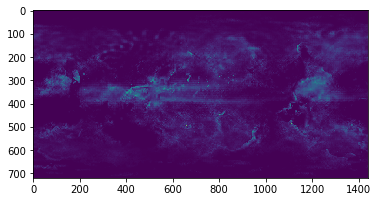

In [67]:
plt.imshow(pr_arr1971[0,:,:])